In [1]:
# import necessary modules 
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf
import math as math
import pandas as pd
from matplotlib import gridspec
import datetime as dt 
import glob
import seaborn as sns
from datetime import datetime

In [2]:
def get_datetime(year, month, day, sec):
        
    Y = year
    M = month
    D = day
    
    hours = sec/3600.
    
    if (hours>=24)&(hours<48):
        D=day+1
        hours = (sec/3600.)-24
        
    if hours>=48:
        D=day+2
        hours = (sec/3600.)-48   
        
    if (M==12) & (D>31):
        D=D-31
        M = 1
        Y = year+1
        
    if (M==1) & (D>31):
        D=D-31
        M = 2
        
    if (M==2) & (D>28):
        D=D-28
        M = 3

    h = int(np.floor(hours))
    
    minutes = (hours-h)*60.
    m = int(np.floor(minutes))

    seconds = (minutes-m)*60.
    s = int(np.floor(seconds))
        
    datetime_fmt = dt.datetime(Y,M,D,h,m,s)
        
    return(datetime_fmt)


def get_datetime_GV(month, day, time):
    datetime = []
    for k in range(len(time)):
        D = day 
        M = month
        Y = 2018

        sec = time[k]

        hours = sec/3600.
        h = int(np.floor(hours))

        minutes = (hours-h)*60.
        m = int(np.floor(minutes))

        seconds = (minutes-m)*60.
        s = int(np.floor(seconds))

        if h>=24:
            h = h-24
            D = D+1
            if (M==1) & (D>=31):
                M = M+1
                D = 1
            if (M==2) & (D>=28):
                M = M+1
                D = 1
            if (M==3) & (D>=31):
                M = M+1
                D = 1

        datetime_fmt = dt.datetime(int(Y),int(M),int(D),h,m,s)
        datetime.append(datetime_fmt)
    return(datetime)

# create function to read date and seconds and change to datetime data type
# input variables
# date in YYYYMMDD format
# sec in seconds of day 
# out variable 
# datetime data in YYYY-MM-DD HH:MM:SS

def get_datetime_cam(date, sec):
    date_string = str(date)
    
    Y = int(date_string[:4])
    M = int(date_string[4:6])
    D = int(date_string[6:8])
    
    hours = sec/3600.
    h = int(np.floor(hours))

    minutes = (hours-h)*60.
    m = int(np.floor(minutes))

    seconds = (minutes-m)*60.
    s = int(np.floor(seconds))
    
    datetime_fmt = dt.datetime(Y,M,D,h,m,s)
        
    return(datetime_fmt)


# function for finding nearest time index
def nearest_ind(items, pivot):
    time_diff = np.abs([date - pivot for date in items])
    return time_diff.argmin(0)


def calc_ws(u,v):
    ws = np.sqrt(((u**2.)+(v**2.)))
    return ws


# --------------------------------------------------------------------------------
# surface area
def calc_Stot(Nt, Dgnd, sigma):
    a = (np.log(sigma))**2.
    Stot = math.pi*Nt*(Dgnd**2.)*np.exp(2.*a)
    return Stot

# --------------------------------------------------------------------------------
# surface area
def calc_Vtot(Nt, Dgnd, sigma):
    a = (np.log(sigma))**2.
    Vtot = (math.pi/6.)*Nt*(Dgnd**3.)*np.exp((9./2.)*a)
    return Vtot


# --------------------------------------------------------------------------------
#total number concentrations, bounded
def calc_Nbound(Nt, Dgnd, sigma, Dmin, Dmax):
    from scipy.special import erf
    term_max = np.log(Dmax/Dgnd)/(np.sqrt(2.)*np.log(sigma))
    term_min = np.log(Dmin/Dgnd)/(np.sqrt(2.)*np.log(sigma))
    Nbound = ((Nt/2.)*(erf(term_max)-erf(term_min))) 
    return Nbound

# --------------------------------------------------------------------------------
# DeMott et al., 2015 parameterization: 
# Constants:
D15_cf = 3. 
D15_alpha = 0. 
D15_beta = 1.25 
D15_gam = 0.46
D15_d = -11.6
Tk = 273.15

#INPUT: 
# n500 = number concentration of particles larger than 500 nm [=] per cubic meter
# T = temperature [=] C
# OUTPUT: 
# D10_INP = number concentration of INPs from mineral dust aerosol [=] per L
def D15(n500, T):
    T_inK = Tk+T
    D15_INP = D15_cf*((n500/(100.**3))**(D15_alpha*(Tk-T_inK)+D15_beta))*np.exp(D15_gam*(Tk-T_inK)+D15_d)
    return D15_INP

# --------------------------------------------------------------------------------
#### McCluskey et al., 2018 parameterization: 
# constants: 
M18_a = -0.545
M18_b = 1.0125
# INPUT: 
# Stot = surface area of ss aerosol [=] m2/m3
# T = temperature [=] C
# OUTPUT: 
# M18_ns = nucleation site density [=] #/m2
def M18(T):
    T_k = T+273.15
    M18_ns = np.exp(M18_a*(T_k-273.15)+M18_b) # [=] #/m2
    return M18_ns


# --------------------------------------------------------------------------------
#### Neimand et al., 2012 parameterization: 
# constants: 
N12_a = -0.517
N12_b = 8.934
# INPUT: 
# Stot = surface area of ss aerosol [=] m2/m3
# T = temperature [=] C
# OUTPUT: 
# N12_ns = nucleation site density [=] #/m2
def N12(T):
    T_k = T+273.15
    N12_ns = np.exp(N12_a*(T_k-273.15)+N12_b) # [=] #/m2
    return N12_ns



def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

## READ IN GV DATA FROM DATA FRAMES 


In [3]:
df_directory = '/Users/cmcclus/Documents/projects/SOAR/SOC/SOC_research_themes/methods/flightlev_CAM6/'


GV_filename = df_directory+'flightlevel_all_GV_SOCRATES.csv'
gv_df = pd.read_csv(GV_filename,sep=',')
gv_df.columns


# convert datetime from str to datetime 
datetime_use = []
for i in range(len(gv_df)):
    type(gv_df.datetime[i])
    datetime_use.append(datetime.strptime(gv_df.datetime[i],'%Y-%m-%d %H:%M:%S'))
    
gv_df.drop(columns=['datetime'])
gv_df['datetime'] = np.array(datetime_use)
gv_df.columns

Index(['Unnamed: 0', 'datetime', 'pressure', 'lat', 'lon', 'relhum', 'temp',
       'cwc_cdp', 'w', 'Z', 'Ncn', 'ws', 'CVINLET', 'CVTS', 'PLWCC', 'LWC2DC',
       'nUHSAS_full', 'nUHSAS_CVI_full', 'nUHSAS_full_rm',
       'nUHSAS_CVI_full_rm', 'nUHSAS_CVI_trunc', 'nUHSAS_CVI_trunc_rm',
       'nUHSAS_trunc', 'nUHSAS_trunc_rm'],
      dtype='object')

## READ IN CAM6 DATA

In [4]:
cam_directory = '/Users/cmcclus/Documents/projects/CAM_simulations/'
filename = cam_directory+'cam6_2032_sd_soar_base_MG3_01252023.cam.hs.2017_2018.merged.nc'
# filename = cam_directory+'cam600_sd_micre_03v4_4.merged.nc'
cam6_nc = netcdf.netcdf_file(filename, 'r')

instr_num = cam6_nc.variables['instr_num'][:]
orbitnum = cam6_nc.variables['orbit_num'][:]

# lat, lon, time
lat = cam6_nc.variables['lat'][instr_num==32] 
lon = cam6_nc.variables['lon'][instr_num==32] 
time = cam6_nc.variables['time'][instr_num==32] 
Z = cam6_nc.variables['Z3'][instr_num==32] 

instr_lat = cam6_nc.variables['instr_lat'][instr_num==32] 
instr_lon = cam6_nc.variables['instr_lon'][instr_num==32]  
obs_time = cam6_nc.variables['obs_time'][instr_num==32] 
obs_date = cam6_nc.variables['obs_date'][instr_num==32]

# hybrid grid-related variables 
P0 = cam6_nc.variables['P0'][...] 
hyam = cam6_nc.variables['hyam'][...]
hybm = cam6_nc.variables['hybm'][...] 

# Met variables: 
T = cam6_nc.variables['T'][instr_num==32] # temperature  [=] K
PS = cam6_nc.variables['PS'][instr_num==32] # surface pressure [=] Pa
RH = cam6_nc.variables['RELHUM'][instr_num==32] # relative hum. [=] % 
U = cam6_nc.variables['U'][instr_num==32] # wind speed U component
V = cam6_nc.variables['V'][instr_num==32] # wind speed V component

cam6_datetime = []
for i in range(len(obs_date)):
    cam6_datetime.append(get_datetime_cam(obs_date[i],obs_time[i]))

d_test = {'datetime':np.array(cam6_datetime)}

# cam6_datetime= np.array(cam6_datetime)
cam6_df = pd.DataFrame(data=d_test)

# -----------------------------------------------------------------------------------------------
# CALCULATE SOME MET VARIABLES
# calc wind speed
ws = calc_ws(U, V)
ws_surf = ws[:,-1]

#convert model T to deg C 
T_C = T-273.15 

# calculate pressure levels from hybrid grid 
P_CAM_dummy_h = P0*hyam
midP = P_CAM_dummy_h+(hybm*PS[:,None]) # [=] Pa 
midP_hPa = midP*0.01 # [=] hPa 

#calcuate mass density for all levels 
Rdry = 287.
massdens = midP / T / Rdry # [=] kg/m3

# calcualted stp mass density
stp_P = 101325.
stp_T = 273.15
massdens_stp = massdens*(stp_P/midP)*(T/stp_T) # [=] kg/m3

# -----------------------------------------------------------------------------------------------
# READ IN AEROSOL VARIABLES

# mass concentrations [=] kg/kg
bc_a1 = cam6_nc.variables['bc_a1'][instr_num==32] 
# bc_c1 = cam6_nc.variables['bc_c1'][instr_num==32] 

dst_a1 = cam6_nc.variables['dst_a1'][instr_num==32] 
# dst_c1 = cam6_nc.variables['dst_c1'][instr_num==32] 
dst_a3 = cam6_nc.variables['dst_a3'][instr_num==32] 
# dst_c3 = cam6_nc.variables['dst_c3'][instr_num==32] 

ncl_a1 = cam6_nc.variables['ncl_a1'][instr_num==32] 
ncl_a2 = cam6_nc.variables['ncl_a2'][instr_num==32] 
ncl_a3 = cam6_nc.variables['ncl_a3'][instr_num==32]
# ncl_c1 = cam6_nc.variables['ncl_c1'][instr_num==32] 
# ncl_c2 = cam6_nc.variables['ncl_c2'][instr_num==32] 
# ncl_c3 = cam6_nc.variables['ncl_c3'][instr_num==32] 

pom_a1 = cam6_nc.variables['pom_a1'][instr_num==32] 
pom_a4 = cam6_nc.variables['pom_a4'][instr_num==32] 
# pom_c1 = cam6_nc.variables['pom_c1'][instr_num==32] 
# pom_c4 = cam6_nc.variables['pom_c4'][instr_num==32] 

so4_a1 = cam6_nc.variables['so4_a1'][instr_num==32] 
so4_a2 = cam6_nc.variables['so4_a2'][instr_num==32] 
so4_a3 = cam6_nc.variables['so4_a3'][instr_num==32] 
# so4_c1 = cam6_nc.variables['so4_c1'][instr_num==32]
# so4_c2 = cam6_nc.variables['so4_c2'][instr_num==32] 
# so4_c3 = cam6_nc.variables['so4_c3'][instr_num==32] 

soa_a1 = cam6_nc.variables['soa_a1'][instr_num==32] 
soa_a2 = cam6_nc.variables['soa_a2'][instr_num==32] 
# soa_c1 = cam6_nc.variables['soa_c1'][instr_num==32] 
# soa_c2 = cam6_nc.variables['soa_c2'][instr_num==32]

# number concentrations [=] 1/kg
num_a1 = cam6_nc.variables['num_a1'][instr_num==32] 
num_a2 = cam6_nc.variables['num_a2'][instr_num==32] 
num_a3 = cam6_nc.variables['num_a3'][instr_num==32] 
num_a4 = cam6_nc.variables['num_a4'][instr_num==32]
# num_c1 = cam6_nc.variables['num_c1'][instr_num==32] 
# num_c2 = cam6_nc.variables['num_c2'][instr_num==32]
# num_c3 = cam6_nc.variables['num_c3'][instr_num==32]
# num_c4 = cam6_nc.variables['num_c4'][instr_num==32]

num01 = num_a1
num02 = num_a2
num03 = num_a3
num04 = num_a4

# dry diameter [=] m
dgnd_a01 = cam6_nc.variables['dgnd_a01'][instr_num==32]
dgnd_a02 = cam6_nc.variables['dgnd_a02'][instr_num==32]
dgnd_a03 = cam6_nc.variables['dgnd_a03'][instr_num==32]
dgnd_a04 = cam6_nc.variables['dgnd_a04'][instr_num==32] 

# # wet diameter [=] m
# dgnw_a01 = cam6_nc.variables['dgnw_a01'][instr_num==32]
# dgnw_a02 = cam6_nc.variables['dgnw_a02'][instr_num==32] 
# dgnw_a03 = cam6_nc.variables['dgnw_a03'][instr_num==32] 
# dgnw_a04 = cam6_nc.variables['dgnw_a04'][instr_num==32] 

# Define sigma for each mode - from e-mail on Mar 8: 
sigma_1 = 1.6
sigma_2 = 1.6
sigma_3 = 1.8
sigma_4 = 1.6

# -----------------------------------------------------------------------------------------------
# CALCULATE AEROSOL VARIABLES -- ALL AEROSOL (IN-CLOUD + INTERSTITIAL)
perm3_to_percc=1.e-6

# TOTAL MASS CONCENTRATIONS (kg/kg)
m_ac1_tot = (bc_a1 + dst_a1 + ncl_a1 +
            pom_a1 + so4_a1 + soa_a1) # [=] kg/kg
m_ac2_tot = so4_a2 + soa_a2 + ncl_a2 # [=] kg/kg
m_ac3_tot = dst_a3 + ncl_a3+ so4_a3 # [=] kg/kg
m_ac4_tot = pom_a4  # [=] kg/kg
m_allmodes_tot = m_ac1_tot + m_ac2_tot + m_ac3_tot + m_ac4_tot # [=] kg/kg

# SPECIATED MASS FRACTIONS (dimensionless)
Fbc_ac1 = (bc_a1)/m_ac1_tot

Fdst_ac1 = (dst_a1)/m_ac1_tot 
Fdst_ac3 = (dst_a3)/m_ac3_tot 

Fncl_ac1 = (ncl_a1)/m_ac1_tot 
Fncl_ac2 = (ncl_a2)/m_ac2_tot 
Fncl_ac3 = (ncl_a3)/m_ac3_tot 

Fpom_ac1 = (pom_a1)/m_ac1_tot
Fpom_ac4 = (pom_a4)/m_ac4_tot

Fso4_ac1 = (so4_a1)/m_ac1_tot
Fso4_ac2 = (so4_a2)/m_ac2_tot
Fso4_ac3 = (so4_a3)/m_ac3_tot 

Fsoa_ac1 = (soa_a1)/m_ac1_tot 
Fsoa_ac2 = (soa_a2)/m_ac2_tot 

# surface area calcs
Stot_ac1 = calc_Stot(num_a1, dgnd_a01, sigma_1)# [=] m2/kg
Stot_ac2 = calc_Stot(num_a2, dgnd_a02, sigma_2) # [=] m2/kg
Stot_ac3 = calc_Stot(num_a3, dgnd_a03, sigma_3) # [=] m2/kg
Stot_ac4 = calc_Stot(num_a4, dgnd_a04, sigma_4) # [=] m2/kg

# surface area of sea salt
ss_SA_tot = ((Fncl_ac1*Stot_ac1)+(Fncl_ac2*Stot_ac2)+(Fncl_ac3*Stot_ac3))*massdens_stp # [=] m2/m3
ss_SA_sub = ((Fncl_ac1*Stot_ac1)+(Fncl_ac2*Stot_ac2))*massdens_stp # [=] m2/m3

#surface area of dust aerosol 
Stot_dst = ((Fdst_ac1*Stot_ac1)+(Fdst_ac3*Stot_ac3))*massdens_stp # [=] m2/m3

#surface area of total aerosol 
Stot_tot = (Stot_ac1+Stot_ac2+Stot_ac3+Stot_ac4)*massdens_stp # [=] m2/m3

# n500 of dust aerosol 
microns2m = 1.e-6
Dmin = 0.5*microns2m
Dmax = 10.*microns2m

n500_ac1  = (calc_Nbound(num_a1, dgnd_a01, sigma_1,
                  Dmin, Dmax)* massdens_stp)# num per m3
n500_ac3  = (calc_Nbound(num_a3, dgnd_a03, sigma_3, 
                 Dmin, Dmax)* massdens_stp)# num per m3

# calculate n500 from dust aerosol - needed for D15 parameterization
n500_dst = (Fdst_ac1*n500_ac1)+(Fdst_ac3*n500_ac3) # [=] per m3 (massdensity included up above)

# calculate bounded number concentrations corresponding to GV instruments 
microns2m = 1.e-6

# ----------------- GV Wing-mounted UHSAS ----------------- 
# 0.059 < Dp < 1.022 µm
Dmin = 0.07*microns2m
Dmax = 1.0*microns2m
nUHSAS_ac1 = (calc_Nbound(num_a1, dgnd_a01, sigma_1,
                  Dmin, Dmax)* massdens_stp)
nUHSAS_ac2 = (calc_Nbound(num_a2, dgnd_a02, sigma_2,
                  Dmin, Dmax)* massdens_stp)
nUHSAS_ac3 = (calc_Nbound(num_a3, dgnd_a03, sigma_3,
                  Dmin, Dmax)* massdens_stp)
nUHSAS_ac4 = (calc_Nbound(num_a4, dgnd_a04, sigma_4,
                  Dmin, Dmax)* massdens_stp)
cam_N_UHSAS = nUHSAS_ac1 + nUHSAS_ac2 + nUHSAS_ac3 + nUHSAS_ac4



# ----------------- GNI ----------------- 
# 1.4 < Dp < 16 µm
Dmin = 1.4*microns2m
Dmax = 16*microns2m
num_ncl_ac1 = Fncl_ac1*(num_a1)
num_ncl_ac2 = Fncl_ac2*(num_a2) 
num_ncl_ac3 = Fncl_ac3*(num_a3) 

nGNI_ac1 = (calc_Nbound(num_ncl_ac1, dgnd_a01, sigma_1,
                  Dmin, Dmax)* massdens_stp)
nGNI_ac2 = (calc_Nbound(num_ncl_ac2, dgnd_a02, sigma_2,
                  Dmin, Dmax)* massdens_stp)
nGNI_ac3 = (calc_Nbound(num_ncl_ac3, dgnd_a03, sigma_3,
                  Dmin, Dmax)* massdens_stp)
cam_N_gni = nGNI_ac1 + nGNI_ac2 + nGNI_ac3 

# ----------------- TEM small ----------------- 
# 0.1 < Dp < 0.5 µm
Dmin = 0.1*microns2m
Dmax = 0.5*microns2m
nTEMsml_ac1 = (calc_Nbound(num_a1, dgnd_a01, sigma_1,
                  Dmin, Dmax)* massdens_stp)
nTEMsml_ac2 = (calc_Nbound(num_a2, dgnd_a02, sigma_2,
                  Dmin, Dmax)* massdens_stp)
nTEMsml_ac3 = (calc_Nbound(num_a3, dgnd_a03, sigma_3,
                  Dmin, Dmax)* massdens_stp)
nTEMsml_ac4 = (calc_Nbound(num_a4, dgnd_a04, sigma_4,
                  Dmin, Dmax)* massdens_stp)
cam_N_TEMsml = nTEMsml_ac1 + nTEMsml_ac2 + nTEMsml_ac3 + nTEMsml_ac4

# ----------------- TEM large ----------------- 
# 0.5 < Dp < 2.5 µm
Dmin = 0.5*microns2m
Dmax = 5*microns2m
nTEMlrg_ac1 = (calc_Nbound(num_a1, dgnd_a01, sigma_1,
                  Dmin, Dmax)* massdens_stp)
nTEMlrg_ac2 = (calc_Nbound(num_a2, dgnd_a02, sigma_2,
                  Dmin, Dmax)* massdens_stp)
nTEMlrg_ac3 = (calc_Nbound(num_a3, dgnd_a03, sigma_3,
                  Dmin, Dmax)* massdens_stp)
nTEMlrg_ac4 = (calc_Nbound(num_a4, dgnd_a04, sigma_4,
                  Dmin, Dmax)* massdens_stp)
cam_N_TEMlrg = nTEMlrg_ac1 + nTEMlrg_ac2 + nTEMlrg_ac3 + nTEMlrg_ac4

## CREATE DATAFRAME OF CAM6 DATA CO-LOCATED WITH GV 

In [5]:
# ### Set up arrays for trimmed CAM output 
# # state variables
# CAM_fp_datetime = []
# CAM_fp_lat = []
# CAM_fp_lon = []
# CAM_fp_Z = []
# CAM_fp_P = []
# CAM_fp_T = []
# CAM_fp_RH = []
# CAM_fp_ws = []
# CAM_fp_ws_srf = []
# CAM_fp_T_srf = []

# # INP prediction variables 
# CAM_fp_dst_n500 = []
# CAM_fp_dst_SA = []
# CAM_fp_ss_SA_tot = []
# CAM_fp_ss_SA_sub = []

# # integrated size distribution variable 
# CAM_fp_N_UHSAS = []
# CAM_fp_N_GNI = []

# # needed for composition comparison
# CAM_N_TEMsml = []
# CAM_N_TEMlrg = []
# CAM_Fbc01 = []
# # CAM_Fbc04 = []
# CAM_Fdst01 = []
# CAM_Fdst03 = []
# CAM_Fncl01 = []
# CAM_Fncl02 = []
# CAM_Fncl03 = []
# CAM_Fpom01 = []
# CAM_Fpom04 = []
# CAM_Fso401 = []
# CAM_Fso402 = []
# CAM_Fso403 = []
# CAM_Fsoa01 = []
# CAM_Fsoa02 = []
# CAM_num01 = []
# CAM_num02 = []
# CAM_num03 = []
# CAM_num04 = []
# CAM_dgnd01 = []
# CAM_dgnd02 = []
# CAM_dgnd03 = []
# CAM_dgnd04 = []


# for i in range(3):#(len(gv_df))): 
#     t = gv_df.datetime.iloc[i]  
#     P = gv_df.pressure.iloc[i]                                       # observed pressure
    
#     # find CAM time and level closest to observed time (t) and pressure (P) 
#     t_dummy = nearest_ind(cam6_df.datetime,t)                            
#     P_dummy = np.abs(midP_hPa[t_dummy,:]-P) 

#     t_case = t_dummy
#     P_case = np.argmin(P_dummy)
#     # pull out CAM output from time and pressure level of interest  
#     # state variables
#     CAM_fp_datetime.append(cam6_df.datetime[t_dummy])
#     CAM_fp_lat.append(lat[t_dummy])
#     CAM_fp_lon.append(lon[t_dummy])
#     CAM_fp_Z.append(Z[t_case,P_case])
#     CAM_fp_P.append(midP_hPa[t_dummy, (np.argmin(P_dummy))])
#     CAM_fp_T.append(T_C[t_dummy, (np.argmin(P_dummy))])
# #     CAM_fp_RH.append(RH[t_dummy, (np.argmin(P_dummy))])
# #     CAM_fp_ws.append(ws[t_dummy, (np.argmin(P_dummy))])
# #     CAM_fp_ws_srf.append(ws_surf[t_dummy])
# #     CAM_fp_T_srf.append(T_C[t_dummy, -1])
    
# #     # variables needed for INP prediction 
# #     CAM_fp_dst_n500.append(n500_dst[t_dummy, (np.argmin(P_dummy))])
# #     CAM_fp_dst_SA.append(Stot_dst[t_dummy, (np.argmin(P_dummy))])
# #     CAM_fp_ss_SA_tot.append(ss_SA_tot[t_dummy, (np.argmin(P_dummy))])
# #     CAM_fp_ss_SA_sub.append(ss_SA_sub[t_dummy, (np.argmin(P_dummy))])
    
# #     # variables for size distribution simulators
# #     CAM_fp_N_UHSAS.append(cam_N_UHSAS[t_dummy, (np.argmin(P_dummy))])
# #     CAM_fp_N_GNI.append(cam_N_gni[t_dummy, (np.argmin(P_dummy))])
    
# #     # variables needed for TEM comparison 
# #     CAM_N_TEMsml.append(cam_N_TEMsml[t_dummy, (np.argmin(P_dummy))])
# #     CAM_N_TEMlrg.append(cam_N_TEMlrg[t_dummy, (np.argmin(P_dummy))])
    
# #     CAM_Fbc01.append(Fbc_ac1[t_dummy, (np.argmin(P_dummy))])
    
# #     CAM_Fdst01.append(Fdst_ac1[t_dummy, (np.argmin(P_dummy))])
# #     CAM_Fdst03.append(Fdst_ac3[t_dummy, (np.argmin(P_dummy))])
    
# #     CAM_Fncl01.append(Fncl_ac1[t_dummy, (np.argmin(P_dummy))])
# #     CAM_Fncl02.append(Fncl_ac2[t_dummy, (np.argmin(P_dummy))])
# #     CAM_Fncl03.append(Fncl_ac3[t_dummy, (np.argmin(P_dummy))])
    
# #     CAM_Fpom01.append(Fpom_ac1[t_dummy, (np.argmin(P_dummy))])
# #     CAM_Fpom04.append(Fpom_ac4[t_dummy, (np.argmin(P_dummy))])
    
# #     CAM_Fso401.append(Fso4_ac1[t_dummy, (np.argmin(P_dummy))])
# #     CAM_Fso402.append(Fso4_ac2[t_dummy, (np.argmin(P_dummy))])
# #     CAM_Fso403.append(Fso4_ac3[t_dummy, (np.argmin(P_dummy))])
    
# #     CAM_Fsoa01.append(Fsoa_ac1[t_dummy, (np.argmin(P_dummy))])
# #     CAM_Fsoa02.append(Fsoa_ac2[t_dummy, (np.argmin(P_dummy))])
    
# #     CAM_num01.append(num01[t_dummy, (np.argmin(P_dummy))])
# #     CAM_num02.append(num02[t_dummy, (np.argmin(P_dummy))])
# #     CAM_num03.append(num03[t_dummy, (np.argmin(P_dummy))])
# #     CAM_num04.append(num04[t_dummy, (np.argmin(P_dummy))])
    
# #     CAM_dgnd01.append(dgnd_a01[t_dummy, (np.argmin(P_dummy))])
# #     CAM_dgnd02.append(dgnd_a02[t_dummy, (np.argmin(P_dummy))])
# #     CAM_dgnd03.append(dgnd_a03[t_dummy, (np.argmin(P_dummy))])
# #     CAM_dgnd04.append(dgnd_a04[t_dummy, (np.argmin(P_dummy))])
    

In [6]:
### Set up arrays for trimmed CAM output 
# state variables
CAM_fp_datetime = []
CAM_fp_lat = []
CAM_fp_lon = []
CAM_fp_Z = []
CAM_fp_P = []
CAM_fp_T = []
CAM_fp_RH = []
CAM_fp_ws = []
CAM_fp_ws_srf = []
CAM_fp_T_srf = []

# INP prediction variables 
CAM_fp_dst_n500 = []
CAM_fp_dst_SA = []
CAM_fp_ss_SA_tot = []
CAM_fp_ss_SA_sub = []

# integrated size distribution variable 
CAM_fp_N_UHSAS = []
CAM_fp_N_GNI = []

# needed for composition comparison
CAM_N_TEMsml = []
CAM_N_TEMlrg = []
CAM_Fbc01 = []
# CAM_Fbc04 = []
CAM_Fdst01 = []
CAM_Fdst03 = []
CAM_Fncl01 = []
CAM_Fncl02 = []
CAM_Fncl03 = []
CAM_Fpom01 = []
CAM_Fpom04 = []
CAM_Fso401 = []
CAM_Fso402 = []
CAM_Fso403 = []
CAM_Fsoa01 = []
CAM_Fsoa02 = []
CAM_num01 = []
CAM_num02 = []
CAM_num03 = []
CAM_num04 = []
CAM_dgnd01 = []
CAM_dgnd02 = []
CAM_dgnd03 = []
CAM_dgnd04 = []


for i in range((len(gv_df))): 
    t = gv_df.datetime.iloc[i]  
    P = gv_df.pressure.iloc[i]
    Z_obs = gv_df.Z.iloc[i]    
    
    # find CAM time and level closest to observed time (t) and pressure (P) 
    t_dummy = nearest_ind(cam6_df.datetime,t)                            
    if P>0:
        P_dummy = np.abs(midP_hPa[t_dummy,:]-P) 
    else: 
        P_dummy = np.abs(Z[t_dummy,:]-Z_obs) 

    t_case = t_dummy
    P_case = np.argmin(P_dummy)
    # pull out CAM output from time and pressure level of interest  
    # state variables
    CAM_fp_datetime.append(cam6_df.datetime[t_dummy])
    CAM_fp_lat.append(lat[t_dummy])
    CAM_fp_lon.append(lon[t_dummy])
    CAM_fp_Z.append(Z[t_case, P_case])
    CAM_fp_P.append(midP_hPa[t_case, P_case])
    CAM_fp_T.append(T_C[t_case, P_case])
    CAM_fp_RH.append(RH[t_case, P_case])
    CAM_fp_ws.append(ws[t_case, P_case])
    CAM_fp_ws_srf.append(ws_surf[t_dummy])
    CAM_fp_T_srf.append(T_C[t_dummy, -1])
    
    # variables needed for INP prediction 
    CAM_fp_dst_n500.append(n500_dst[t_case, P_case])
    CAM_fp_dst_SA.append(Stot_dst[t_case, P_case])
    CAM_fp_ss_SA_tot.append(ss_SA_tot[t_case, P_case])
    CAM_fp_ss_SA_sub.append(ss_SA_sub[t_case, P_case])
    
    # variables for size distribution simulators
    CAM_fp_N_UHSAS.append(cam_N_UHSAS[t_case, P_case])
    CAM_fp_N_GNI.append(cam_N_gni[t_case, P_case])
    
    # variables needed for TEM comparison 
    CAM_N_TEMsml.append(cam_N_TEMsml[t_case, P_case])
    CAM_N_TEMlrg.append(cam_N_TEMlrg[t_case, P_case])
    
    CAM_Fbc01.append(Fbc_ac1[t_case, P_case])
    
    CAM_Fdst01.append(Fdst_ac1[t_case, P_case])
    CAM_Fdst03.append(Fdst_ac3[t_case, P_case])
    
    CAM_Fncl01.append(Fncl_ac1[t_case, P_case])
    CAM_Fncl02.append(Fncl_ac2[t_case, P_case])
    CAM_Fncl03.append(Fncl_ac3[t_case, P_case])
    
    CAM_Fpom01.append(Fpom_ac1[t_case, P_case])
    CAM_Fpom04.append(Fpom_ac4[t_case, P_case])
    
    CAM_Fso401.append(Fso4_ac1[t_case, P_case])
    CAM_Fso402.append(Fso4_ac2[t_case, P_case])
    CAM_Fso403.append(Fso4_ac3[t_case, P_case])
    
    CAM_Fsoa01.append(Fsoa_ac1[t_case, P_case])
    CAM_Fsoa02.append(Fsoa_ac2[t_case, P_case])
    
    CAM_num01.append(num01[t_case, P_case])
    CAM_num02.append(num02[t_case, P_case])
    CAM_num03.append(num03[t_case, P_case])
    CAM_num04.append(num04[t_case, P_case])
    
    CAM_dgnd01.append(dgnd_a01[t_case, P_case])
    CAM_dgnd02.append(dgnd_a02[t_case, P_case])
    CAM_dgnd03.append(dgnd_a03[t_case, P_case])
    CAM_dgnd04.append(dgnd_a04[t_case, P_case])

In [7]:
d = {'CAM_datetime':np.array(CAM_fp_datetime),
     'CAM_pressure':np.array(CAM_fp_P),
     'CAM_lat':np.array(CAM_fp_lat),
     'CAM_lon':np.array(CAM_fp_lon),
     'CAM_Z':np.array(CAM_fp_Z),
     'CAM_Temp':np.array(CAM_fp_T),
     'CAM_RH':np.array(CAM_fp_RH),
     'CAM_ws':np.array(CAM_fp_ws),
     'CAM_ws_surf':np.array(CAM_fp_ws_srf),
     'CAM_T_surf':np.array(CAM_fp_T_srf),
     'CAM_dst_n500':np.array(CAM_fp_dst_n500),
     'CAM_dst_SA':np.array(CAM_fp_dst_SA),
     'CAM_ss_SA_tot':np.array(CAM_fp_ss_SA_tot),
     'CAM_ss_SA_sub':np.array(CAM_fp_ss_SA_sub),
     'CAM_N_UHSAS':np.array(CAM_fp_N_UHSAS),
     'CAM_N_GNI':np.array(CAM_fp_N_GNI),
     'Fbc01':np.array(CAM_Fbc01),
     'Fdst01':np.array(CAM_Fdst01),
     'Fdst03':np.array(CAM_Fdst03),
     'Fncl01':np.array(CAM_Fncl01),
     'Fncl02':np.array(CAM_Fncl02),
     'Fncl03':np.array(CAM_Fncl03),
     'Fpom01':np.array(CAM_Fpom01),
     'Fpom04':np.array(CAM_Fpom04),
     'Fso401':np.array(CAM_Fso401),
     'Fso402':np.array(CAM_Fso402),
     'Fso403':np.array(CAM_Fso403),
     'Fsoa01':np.array(CAM_Fsoa01),
     'Fsoa02':np.array(CAM_Fsoa02),
     'num01':np.array(CAM_num01),
     'num02':np.array(CAM_num02),
     'num03':np.array(CAM_num03),
     'num04':np.array(CAM_num04),
     'dngd01':np.array(CAM_dgnd01),
     'dngd02':np.array(CAM_dgnd02),
     'dngd03':np.array(CAM_dgnd03),
     'dngd04':np.array(CAM_dgnd04),
     'N_TEMsml':np.array(CAM_N_TEMsml),
     'N_TEMlrg':np.array(CAM_N_TEMlrg)}

In [8]:


CAM_fp_df = pd.DataFrame(data=d)

In [9]:
# merge gv and CAM df 
print(np.shape(gv_df))
print(np.shape(CAM_fp_df))

all_df = pd.concat([gv_df,CAM_fp_df], axis = 1)

print(np.shape(all_df))

(401715, 24)
(401715, 39)
(401715, 63)


(401715, 63)


(0.0, 7000.0)

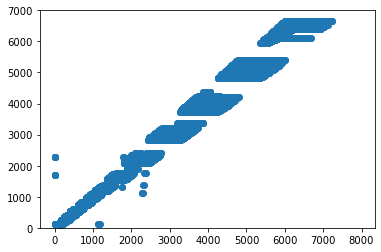

In [10]:
print(np.shape(all_df))
plt.scatter(all_df.Z, CAM_fp_df.CAM_Z)
plt.ylim(0,7000)

In [11]:
save_directory = '/Users/cmcclus/Documents/projects/SOAR/SOC/SOC_research_themes/methods/flightlev_CAM6/'
all_df.to_csv(path_or_buf=save_directory+'flightlevel_all_GV_CAM6_SOCRATES.csv', sep = ',')

In [12]:
all_df.columns

Index(['Unnamed: 0', 'datetime', 'pressure', 'lat', 'lon', 'relhum', 'temp',
       'cwc_cdp', 'w', 'Z', 'Ncn', 'ws', 'CVINLET', 'CVTS', 'PLWCC', 'LWC2DC',
       'nUHSAS_full', 'nUHSAS_CVI_full', 'nUHSAS_full_rm',
       'nUHSAS_CVI_full_rm', 'nUHSAS_CVI_trunc', 'nUHSAS_CVI_trunc_rm',
       'nUHSAS_trunc', 'nUHSAS_trunc_rm', 'CAM_datetime', 'CAM_pressure',
       'CAM_lat', 'CAM_lon', 'CAM_Z', 'CAM_Temp', 'CAM_RH', 'CAM_ws',
       'CAM_ws_surf', 'CAM_T_surf', 'CAM_dst_n500', 'CAM_dst_SA',
       'CAM_ss_SA_tot', 'CAM_ss_SA_sub', 'CAM_N_UHSAS', 'CAM_N_GNI', 'Fbc01',
       'Fdst01', 'Fdst03', 'Fncl01', 'Fncl02', 'Fncl03', 'Fpom01', 'Fpom04',
       'Fso401', 'Fso402', 'Fso403', 'Fsoa01', 'Fsoa02', 'num01', 'num02',
       'num03', 'num04', 'dngd01', 'dngd02', 'dngd03', 'dngd04', 'N_TEMsml',
       'N_TEMlrg'],
      dtype='object')

Text(0.5, 1.0, 'Latitude')

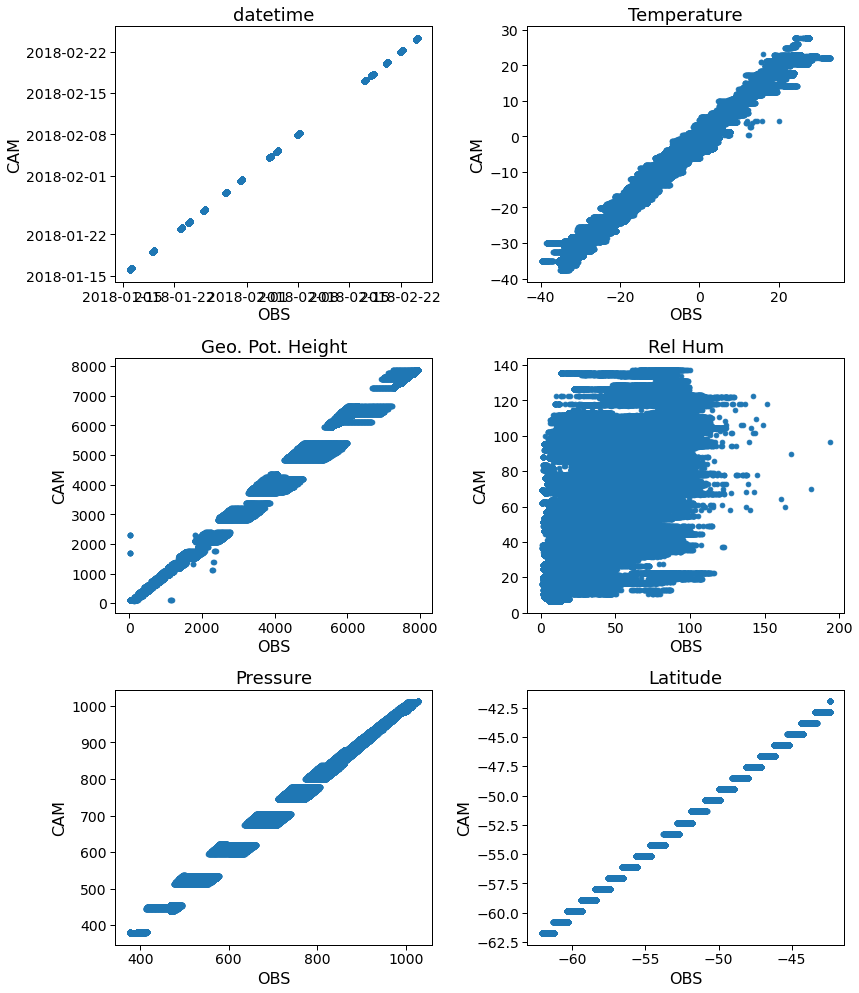

In [13]:
## plot thing to check merging 

### FIG
sns.set_context("paper")

# -------------------------------------------------------------------------------------------
# set axis limts
ymin = 0.0001
ymax = 10
xmin = 0.0001
xmax = 10

# setup figure space
fig = plt.figure(figsize = (15,15))
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1],
             wspace=0.3, hspace=0.3, top=0.95, bottom=0.1, left=0.17, right=0.845) 


# -------------------------------------------------------------------------------------------
ax1 = plt.subplot(gs[0,0])
obs = all_df.datetime
mod = all_df.CAM_datetime
plt.scatter(obs,mod)

plt.tick_params(axis='both', labelsize=14)
plt.ylabel('CAM', fontsize = 16)
plt.xlabel('OBS', fontsize = 16)
plt.title('datetime', fontsize = 18)

# -------------------------------------------------------------------------------------------
ax1 = plt.subplot(gs[1,0])
obs = all_df.Z
mod = all_df.CAM_Z
plt.scatter(obs,mod)

plt.tick_params(axis='both', labelsize=14)
plt.ylabel('CAM', fontsize = 16)
plt.xlabel('OBS', fontsize = 16)
plt.title('Geo. Pot. Height', fontsize = 18)

# -------------------------------------------------------------------------------------------
ax1 = plt.subplot(gs[2,0])
obs = all_df.pressure
mod = all_df.CAM_pressure
plt.scatter(obs,mod)

plt.tick_params(axis='both', labelsize=14)
plt.ylabel('CAM', fontsize = 16)
plt.xlabel('OBS', fontsize = 16)
plt.title('Pressure', fontsize = 18)

# -------------------------------------------------------------------------------------------
ax1 = plt.subplot(gs[0,1])
obs = all_df.temp
mod = all_df.CAM_Temp
plt.scatter(obs,mod)

plt.tick_params(axis='both', labelsize=14)
plt.ylabel('CAM', fontsize = 16)
plt.xlabel('OBS', fontsize = 16)
plt.title('Temperature', fontsize = 18)

# -------------------------------------------------------------------------------------------
ax1 = plt.subplot(gs[1,1])
obs = all_df.relhum
mod = all_df.CAM_RH
plt.scatter(obs,mod)

plt.tick_params(axis='both', labelsize=14)
plt.ylabel('CAM', fontsize = 16)
plt.xlabel('OBS', fontsize = 16)
plt.title('Rel Hum', fontsize = 18)

# -------------------------------------------------------------------------------------------
ax1 = plt.subplot(gs[2,1])
obs = all_df.lat
mod = all_df.CAM_lat
plt.scatter(obs,mod)

plt.tick_params(axis='both', labelsize=14)
plt.ylabel('CAM', fontsize = 16)
plt.xlabel('OBS', fontsize = 16)
plt.title('Latitude', fontsize = 18)

In [14]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

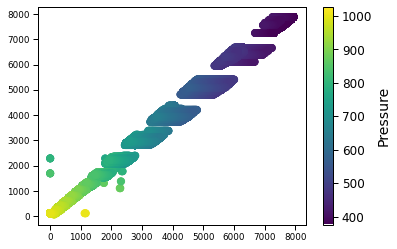

In [15]:

colors = all_df.pressure
plt.scatter(all_df.Z, all_df.CAM_Z, s = 50, marker = 'o', c=colors)#, edgecolor = 'k',linewidth = 0.5, 
#             cmap=discrete_cmap(10,base_cmap=plt.cm.rainbow))

cb=plt.colorbar()
cb.set_label('Pressure', fontsize = 14)
cb.ax.tick_params(labelsize=12)